In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rule  = np.zeros(8, dtype=int)
power = 2**np.arange(0,8,1)
table = np.zeros([256,8], dtype=int)
for i7 in [0, 1]:
    rule[7] = i7
    for i6 in [0, 1]:
        rule[6] = i6
        for i5 in [0, 1]:
            rule[5] = i5
            for i4 in [0, 1]:
                rule[4] = i4
                for i3 in [0, 1]:
                    rule[3] = i3
                    for i2 in [0, 1]:
                        rule[2] = i2
                        for i1 in [0, 1]:
                            rule[1] = i1
                            for i0 in [0, 1]:
                                rule[0] = i0
                                W = int(np.sum(rule*power))
                                table[W] = rule
                                #print(rule, W)
                    
f2list = [18,22,26,28,30,50,54,58,
 60,62,78,90,94,110,122,126,
 146,150,154,156,158,178,182,
 186,188, 190,202,206,218,220,
 234,238,250,254]

In [3]:
def density(W, N=100, M=10, T=50):
    config = np.random.randint(2, size=[M, N])
    probmatrix = np.zeros([M, N])
    
    lambs = np.linspace(0, 1, M)
    final_density = np.zeros(M)
    average_density = np.zeros(M)
    
    conv = np.zeros([8, 2], dtype=int)
    conv[:, 0] = np.array([0, 4, 2, 6, 1, 5, 3, 7])
    conv[:, 1] = table[W]
    code = conv[conv[:,0].argsort()][:, 1]
    
    for t in range(1, T):
        
        index_list  = np.roll(config, 1, axis=1) + 2 * config + 4 * np.roll(config, -1, axis=1)
        
        for m in range(M):
            
            probmatrix[m] = np.random.choice(np.array([0, 1], dtype=int), N, p=[1-lambs[m], lambs[m]])
            
        config = code[index_list] * probmatrix.astype(int)
        
        average_density += np.sum(config , axis = 1)/N
        
    final_density = np.sum(config , axis = 1)/N

    return (lambs, average_density/T, final_density)

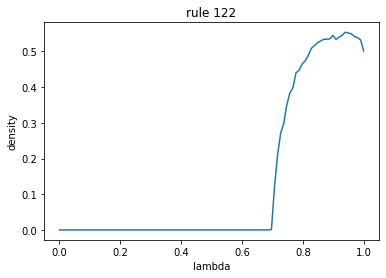

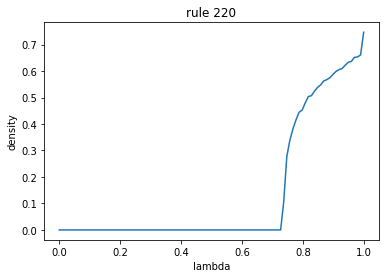

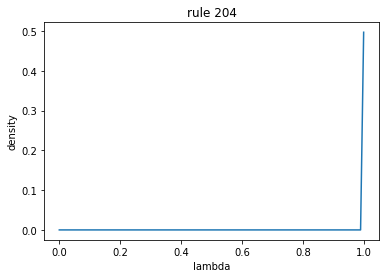

In [26]:
M = 100   # number of lambdas
N = 10000 # number of cells
T =  5000 # run time

for W in [122, 220, 204]:
    lambs, avg, final = density(W, N, M, T)
    
    plt.title('rule '+str(W))
    plt.xlabel('lambda')
    plt.ylabel('density')
    plt.plot(lambs, final)
    plt.savefig('rule'+str(W))
    plt.show()

In [4]:
def error(W, M=10, T=50):
    Ns = np.logspace(2, 4, num=10, dtype='int')
    N  = len(Ns)
    
    error = np.zeros(N)
    
    for i in range(N):
        lambs, avs_dens, final_dens = density(W, Ns[i], M, T)
        error[i] = np.sum((avs_dens - final_dens)**2)
    
    return (Ns, error)

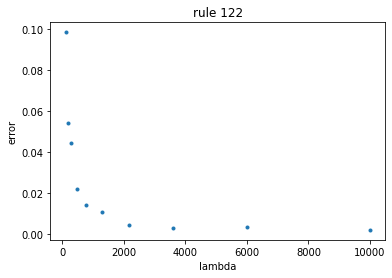

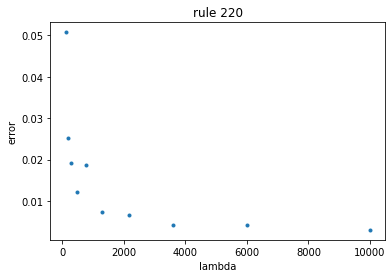

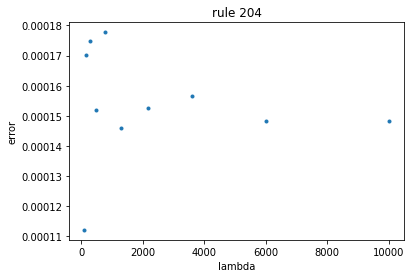

In [28]:
M = 100   # number of lambdas
T =  5000 # run time

for W in [122, 220, 204]:
    Ns, Error = error(W, M, T)
    
    plt.title('rule '+str(W))
    plt.xlabel('lambda')
    plt.ylabel('error')
    plt.plot(Ns, Error, '.')
    plt.savefig('error'+str(W))
    plt.show()

# Learn Multiprocessing

In [5]:
import concurrent.futures

In [6]:
def density_multi(W, lamb, N=100, T=50):
    
    config = np.random.randint(2, size=N)
    
    conv = np.zeros([8, 2], dtype=int)
    conv[:, 0] = np.array([0, 4, 2, 6, 1, 5, 3, 7])
    conv[:, 1] = table[W]
    code = conv[conv[:,0].argsort()][:, 1]
    
    avg_dens = 0
    
    for t in range(1, T):
        
        index_list  = np.roll(config, 1) + 2 * config + 4 * np.roll(config, -1)
            
        probs = np.random.choice(np.array([0, 1], dtype=int), N, p=[1-lamb, lamb])
            
        config = code[index_list] * probs.astype(int)
        
        avg_dens += np.sum(config)/N

    return np.array([avg_dens/T, np.sum(config)/N])

In [11]:
def get_density(W, N = 10000): 
    lambs = np.linspace(0, 1, 100)
    matrix = np.zeros([len(lambs), 2])
    final_dens = np.zeros(len(lambs))

    T =  5000 # run time

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = [executor.submit(density_multi, W, lamb, N, T) for lamb in lambs]

        for i, f in enumerate(concurrent.futures.as_completed(results)):
            matrix[i] = f.result()
    
    avg = matrix[:,0]
    final = matrix[:,1]
    return lambs, avg, final

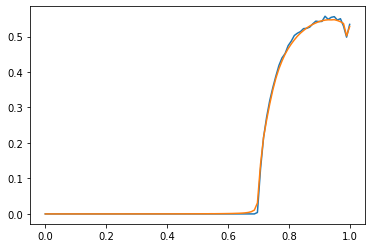

In [6]:
lambs, avg, final = get_density(122)
plt.plot(lambs, final)
plt.plot(lambs, avg)

In [12]:
def get_error(W):
    Ns = np.logspace(2, 4, num=10, dtype='int')
    error = np.zeros(len(Ns))
    for i, N in enumerate(Ns):
        lambs, avg, final = get_density(W, N)
        error[i] = np.sum((avg-final)**2)
    return Ns, error

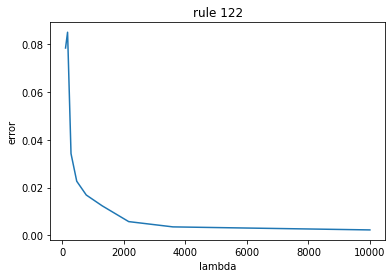

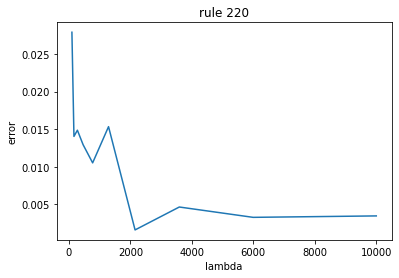

In [13]:
for W in [122, 220]:
    Ns, error = get_error(W)
    plt.plot(Ns, error)
    
    plt.title('rule '+str(W))
    plt.xlabel('lambda')
    plt.ylabel('error')
    plt.savefig('error'+str(W))
    plt.show()